# NNPP
This Notebook reimplements the Method of the Paper from RL 18 to compare results to the pytoch geometric model.
This should archieve a CRPS score around 0.78

In [1]:
import sys
sys.path.append('../utils')
import helpers
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from tqdm import trange

%matplotlib inline
plt.style.use('default')

In [2]:
small = True

In [3]:
# read data (can be downloaded from https://doi.org/10.6084/m9.figshare.13516301.v1)
print("Loading Data ...")
data = helpers.load_data(indexed=False)

print("Cleaning Data ...")
data = helpers.clean_data(data, max_missing=121, max_alt=1000.0)

Loading Data ...
Cleaning Data ...


In [4]:
data

,date,station,obs,t2m_mean,t2m_var,cape_mean,cape_var,sp_mean,sp_var,tcc_mean,...,str_var,d2m_mean,d2m_var,sm_mean,sm_var,lat,lon,alt,orog,doy
0,2007-01-03 00:00:00+00:00,0,5.5,3.616448,0.079733,11.480126,164.398999,101263.773906,17346.641356,46.793524,...,2.810124e+11,275.956692,0.151394,318.990796,6.543392,50.782700,6.0941,202.0,107.439461,-0.983798
1,2007-01-03 00:00:00+00:00,1,2.9,4.601281,0.107129,22.207007,207.708022,101463.529063,18411.594667,48.161629,...,2.771202e+11,275.529611,0.152089,325.635452,8.776818,52.485298,7.9126,65.0,47.632523,-0.983798
2,2007-01-03 00:00:00+00:00,2,3.3,2.873910,0.078148,44.308516,1438.915507,97942.360781,20106.971594,63.223506,...,4.909704e+11,275.008204,0.075718,336.861672,5.635509,50.744598,9.3450,300.0,348.869904,-0.983798
4,2007-01-03 00:00:00+00:00,4,3.4,2.718213,0.198263,96.170580,2550.754359,98045.333437,19122.337645,73.738330,...,7.963386e+11,274.732042,0.186014,324.187435,13.339768,51.088100,12.9326,296.0,296.839203,-0.983798
5,2007-01-03 00:00:00+00:00,5,1.8,1.375332,0.149906,123.618650,1533.808489,96637.034219,16800.454370,91.842461,...,1.033478e+12,274.021844,0.207122,315.014949,20.406193,48.405998,11.3117,510.0,461.575287,-0.983798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1808680,2016-12-31 00:00:00+00:00,530,-0.6,-0.155651,0.978417,0.201357,0.141017,102826.477656,9997.686018,49.609571,...,1.132820e+12,271.254705,1.372146,245.919016,17.199589,52.715599,7.3176,19.0,36.652340,-0.973264
1808940,2016-12-31 00:00:00+00:00,531,-5.3,-3.497557,0.172615,0.003596,0.000317,96513.425000,4798.146479,0.186227,...,1.159146e+11,266.253950,0.827402,395.544220,22.223388,48.441799,9.9216,593.0,532.696167,-0.973264
1808533,2016-12-31 00:00:00+00:00,532,-2.7,-1.661223,0.163165,0.021574,0.006121,102359.503125,8667.898487,7.431432,...,1.425973e+11,269.773757,0.461191,253.349395,13.011937,51.841801,8.0607,104.0,95.691666,-0.973264
1808941,2016-12-31 00:00:00+00:00,533,-1.5,-5.979924,0.349577,0.000000,0.000000,95704.712813,4314.376743,1.796408,...,6.356090e+10,263.174088,0.838257,353.039061,22.348963,47.876099,10.5848,816.0,671.567078,-0.973264


In [5]:
# Get index of last day in 2015
data.reset_index(drop=True, inplace=True)
idx = max(data[data.date.dt.year == 2015].index)
print(idx)
train_start = min(data[data.date.dt.year == 2015].index) if small else 0

1469770


In [6]:
# split into train and test data
eval_start = idx+1
train_end = idx # 2016-12-01

train_features_raw = data.iloc[train_start:train_end,3:].to_numpy()
train_targets = data.iloc[train_start:train_end,2].to_numpy()
train_IDs = data.iloc[train_start:train_end,1].to_numpy()

test_features_raw = data.iloc[eval_start:,3:].to_numpy()
test_targets = data.iloc[eval_start:,2].to_numpy()
test_IDs = data.iloc[eval_start:,1].to_numpy()

In [7]:
# normalize data
def normalize(data, method=None, shift=None, scale=None):
    result = np.zeros(data.shape)
    if method == "MAX":
        scale = np.max(data, axis=0)
        shift = np.zeros(scale.shape)
    for index in range(len(data[0])):
        result[:,index] = (data[:,index] - shift[index]) / scale[index]
    return result, shift, scale

train_features, train_shift, train_scale = normalize(train_features_raw[:,:], method="MAX")

test_features = normalize(test_features_raw[:,:], shift=train_shift, scale=train_scale)[0]

## Neural Newtork

In [8]:
def crps(mu_sigma: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """Calculates the Continuous Ranked Probability Score (CRPS) assuming normally distributed df

    :param torch.Tensor mu_sigma: tensor of mean and standard deviation
    :param torch.Tensor y: observed df

    :return tensor: CRPS value
    :rtype torch.Tensor
    """
    mu, sigma = torch.split(mu_sigma, 1, dim=-1)
    y = y.view((-1,1)) # make sure y has the right shape
    pi = np.pi #3.14159265359
    omega = (y - mu) / sigma
    # PDF of normal distribution at omega
    pdf = 1/(torch.sqrt(torch.tensor(2 * pi))) * torch.exp(-0.5 * omega ** 2)

    # Source: https://stats.stackexchange.com/questions/187828/how-are-the-error-function-and-standard-normal-distribution-function-related
    cdf = 0.5 * (1 + torch.erf(omega / torch.sqrt(torch.tensor(2))))

    crps_score = sigma * (omega * (2 * cdf - 1) + 2 * pdf - 1/torch.sqrt(torch.tensor(pi)))
    return  torch.mean(crps_score)

In [9]:
# Model Definition
class NNPP(nn.Module):
    def __init__(self, INPUT_DIM:int):
        super(NNPP, self).__init__()
        self.emb = nn.Embedding(num_embeddings=535, embedding_dim=2)
        self.lin1 = nn.Linear(in_features=INPUT_DIM+2, out_features=512)
        self.lin2 = nn.Linear(in_features=512, out_features=2)

    def forward(self, x, id):
        emb_station = self.emb(id)
        x = torch.cat((emb_station, x), dim=1) # Concatenate embedded station_id to rest of the feature vector
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        return x

In [10]:
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Convert numpy arrays to tensors and put it in GPU memory for faster training
train_features = torch.tensor(train_features, dtype=torch.float32).to(device)
train_targets = torch.tensor(train_targets, dtype=torch.float32).to(device)
train_IDs = torch.tensor(train_IDs, dtype=torch.int32).to(device)

test_features = torch.tensor(test_features, dtype=torch.float32).to(device)
test_targets = torch.tensor(test_targets, dtype=torch.float32).to(device)
test_IDs = torch.tensor(test_IDs, dtype=torch.int32).to(device)

# Define the batch size
batch_size = 4096
# Create a DataLoader
class DatasetWithID(Dataset):
    def __init__(self, train_target, train_id, train_feature):
        self.train_target = train_target
        self.train_id = train_id
        self.train_features = train_feature

    def __len__(self):
        return len(self.train_target)

    def __getitem__(self, index):
        x = self.train_features[index]
        id = self.train_id[index]
        y = self.train_target[index]
        return x, id, y

cuda


/home/feik/.conda/envs/GNN2/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [11]:
train_dataset = DatasetWithID(train_targets, train_IDs, train_features)
test_dataset = DatasetWithID(test_targets, test_IDs, test_features)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def train(epochs:int, model, optimizer):
    
    epoch_loss = 0
    test_loss = 0
    # Train
    epochs_bar = trange(epochs, desc=f"Training Model {e}", leave=False)
    
    for epoch in epochs_bar:
        for x, id, y in train_loader:
            # Zero gradients
            optimizer.zero_grad()
            # Forward pass
            mu_sigma = model(x, id)
            # Compute the loss
            loss = crps(mu_sigma, y)
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            # Add Loss
            epoch_loss += loss.item()
        epoch_loss /= len(train_loader)
    epochs_bar.close()

    #Eval
    with torch.inference_mode():
        for x, id, y in test_loader:
            # Forward pass
            mu_sigma = model(x, id)
            # Compute the loss
            loss = crps(mu_sigma, y)
            # Add Loss
            test_loss += loss.item()
    test_loss /= len(test_loader)
    return test_loss


# Train Ensemble
model_list = []
test_loss_list = []

trn_scores = []
test_scores = []
preds = []

nreps = 10

for e in range(nreps):
    model = NNPP(INPUT_DIM=test_features.shape[1])
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
    loss = train(epochs=15,
                 model=model,
                 optimizer=optimizer)
    model_list.append(model)
    test_loss_list.append(loss)
print(test_loss_list)

[0.8915388484795889, 0.8858058708054679, 0.8917141727038792, 0.8848567306995392, 0.9250650576182774, 0.8942388807024274, 0.9000936831746783, 0.8861297894091833, 0.8800273580210549, 0.8724480924152193]


In [12]:
def evaluate_ensemble(model_list:list):
    mu_list_model = []
    sigma_list_model = []

    for model in model_list:
        model.eval()
        mu_list_batch = []
        sigma_list_batch = []
        y_list = []

        for x, id, y in test_loader:
            out = model(x, id)
            mu, sigma = torch.split(out, 1, dim=-1)
            y = y.cpu().numpy()
            y_list.append(y)

            mu = mu.detach().cpu().numpy().flatten()
            mu_list_batch.append(mu)
            sigma = sigma.detach().cpu().numpy().flatten()
            sigma_list_batch.append(sigma)


        mu = np.concatenate(mu_list_batch)
        mu_list_model.append(mu)
        sigma = np.concatenate(sigma_list_batch)
        sigma_list_model.append(sigma)
        y = np.concatenate(y_list)
    mu = np.array(mu_list_model).T.mean(axis=1).reshape(-1,1)
    sigma = np.array(sigma_list_model).T.mean(axis=1).reshape(-1,1)

    mu = torch.tensor(mu).to(device)
    sigma = torch.tensor(sigma).to(device)
    preds = torch.cat([mu, sigma], dim=1)
    y = torch.tensor(y).to(device)
    err = crps(mu_sigma=preds, y=y)

    y = y.detach().cpu().numpy()
    mu = mu.detach().cpu().numpy()
    sigma = sigma.detach().cpu().numpy()
    return err, mu, sigma, y

In [13]:
err, mu, sigma, y = evaluate_ensemble(model_list)
print(err)

tensor(0.8759, device='cuda:0')


## Plots

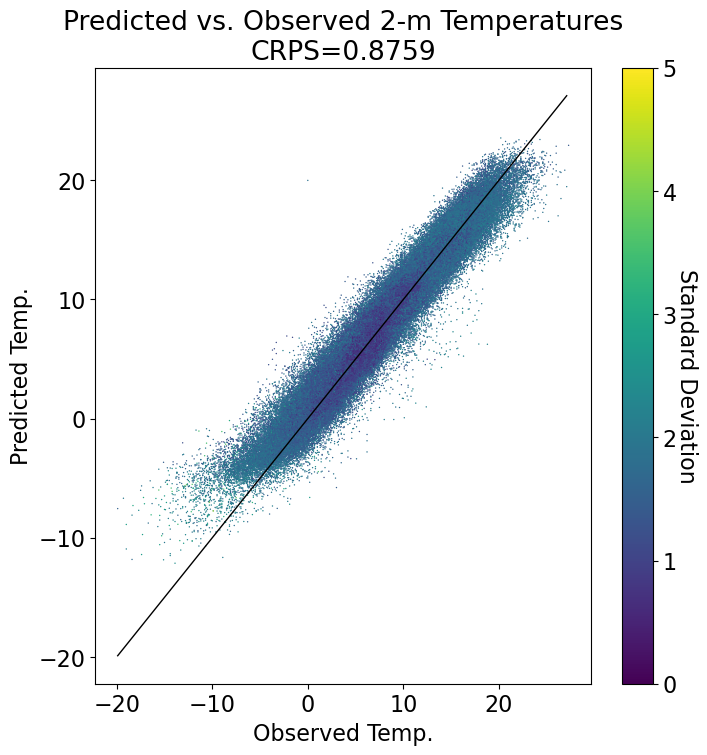

In [14]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(8, 8))
plt.plot(np.arange(np.min(y), np.max(y), 1), np.arange(np.min(y), np.max(y), 1), linewidth=1, color="black")  # line
plt.scatter(y, mu, c=sigma, s=1, linewidth=0, cmap="viridis", vmin=0, vmax=5, rasterized=True)

cbar = plt.colorbar()
cbar.set_label('Standard Deviation', rotation=270, labelpad=15)
plt.xlabel('Observed Temp.')
plt.ylabel('Predicted Temp.')
plt.title(f"Predicted vs. Observed 2-m Temperatures\nCRPS={err:.4f}")
if small:
    plt.savefig(f"../gnn/plots/predsObs_slerch_small.pdf", format='pdf', dpi=600, bbox_inches='tight')
else:
    plt.savefig(f"../gnn/plots/predsObs_slerch.pdf", format='pdf', dpi=600, bbox_inches='tight')

## PIT Histogram

In [15]:
import matplotlib as mpl
from scipy.stats import norm

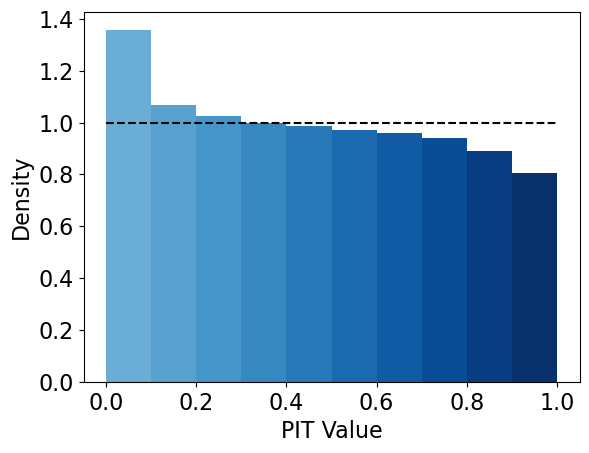

In [16]:
probs = norm.cdf(y.flatten(), loc=mu.flatten(), scale=sigma.flatten())  # scale is standard deviation
n, bins, patches = plt.hist(probs, bins=10, density=True)

# colors
cm = mpl.colormaps['Blues']
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= (max(col))

def scale_interval(value, min_in, max_in, min_out, max_out):
    # Scale value from [min_in, max_in] to [min_out, max_out]
    scaled_value = min_out + (value - min_in) * (max_out - min_out) / (max_in - min_in)
    return scaled_value

col = scale_interval(col, 0, 1, 0.5,1)

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))

plt.hlines(xmin=0,xmax=1, y=1, colors="black", linestyles="--")
plt.xlabel('PIT Value')
plt.ylabel('Density')
if small:
    plt.savefig(f"../gnn/plots/PIT_slerch_small.eps", format='eps', dpi=300, bbox_inches='tight')
else:
    plt.savefig(f"../gnn/plots/PIT_slerch.eps", format='eps', dpi=300, bbox_inches='tight')